In [13]:
import pandas as pd

df = pd.read_csv("nav_with_daily_returns_filtered.csv")
benchmark = pd.read_csv("benchmark_processed.csv")


In [14]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")
benchmark["date"] = pd.to_datetime(benchmark["date"], errors="coerce")


In [15]:
df["date"].isna().sum(), benchmark["date"].isna().sum()
df.dtypes, benchmark.dtypes


(scheme_code                   int64
 scheme_name                  object
 amc                          object
 plan_type                    object
 distribution_type            object
 nav                         float64
 date                 datetime64[ns]
 daily_return                float64
 dtype: object,
 date                datetime64[ns]
 benchmark_value            float64
 benchmark_return           float64
 dtype: object)

In [16]:
df["date"] = df["date"].dt.normalize()
benchmark["date"] = benchmark["date"].dt.normalize()

In [17]:
df_merged = df.merge(
    benchmark,
    on="date",
    how="inner"
)

In [18]:
df_merged.shape
df_merged.head()


,scheme_code,scheme_name,amc,plan_type,distribution_type,nav,date,daily_return,benchmark_value,benchmark_return
0,148918,Aditya Birla Sun Life Multi-Cap Fund-Regular G...,Aditya Birla Sun Life Multi-Cap,Regular,Growth,19.34,2025-01-06,-0.020263,23616.05,NaN
1,148918,Aditya Birla Sun Life Multi-Cap Fund-Regular G...,Aditya Birla Sun Life Multi-Cap,Regular,Growth,19.45,2025-01-07,0.005688,23707.90,0.003889
2,148918,Aditya Birla Sun Life Multi-Cap Fund-Regular G...,Aditya Birla Sun Life Multi-Cap,Regular,Growth,19.21,2025-01-08,-0.012339,23688.95,-0.000799
3,148918,Aditya Birla Sun Life Multi-Cap Fund-Regular G...,Aditya Birla Sun Life Multi-Cap,Regular,Growth,19.03,2025-01-09,-0.009370,23526.50,-0.006858
4,148918,Aditya Birla Sun Life Multi-Cap Fund-Regular G...,Aditya Birla Sun Life Multi-Cap,Regular,Growth,18.71,2025-01-10,-0.016816,23431.50,-0.004038


Cumulative Returns

In [19]:
df_merged = df_merged.sort_values(["scheme_code", "date"])

df_merged["fund_cum_return"] = (
    1 + df_merged["daily_return"]
).groupby(df_merged["scheme_code"]).cumprod() - 1

df_merged["benchmark_cum_return"] = (
    1 + df_merged["benchmark_return"]
).cumprod() - 1


Excess Returns

In [20]:
df_merged["excess_return"] = (
    df_merged["daily_return"] - df_merged["benchmark_return"]
)


In [21]:
df_merged.to_csv(
    "fund_vs_nifty50_performance.csv",
    index=False
)


Summary

In [23]:
import pandas as pd

df = pd.read_csv("fund_vs_nifty50_performance.csv")

summary = (
    df.groupby("scheme_name")
    .agg(
        total_return=("fund_cum_return", "last"),
        benchmark_return=("benchmark_cum_return", "last"),
        avg_daily_return=("daily_return", "mean"),
        volatility=("daily_return", "std"),
        tracking_error=("excess_return", "std"),
        days_analyzed=("date", "nunique")
    )
    .reset_index()
)

summary.to_csv("performance_summary.csv", index=False)
summary


,scheme_name,total_return,benchmark_return,avg_daily_return,volatility,tracking_error,days_analyzed
0,Aditya Birla Sun Life Multi-Cap Fund-Direct Gr...,0.016803,0.355033,0.000108,0.008918,0.004538,244
1,Aditya Birla Sun Life Multi-Cap Fund-Direct ID...,-0.043389,0.224522,-0.000135,0.009661,0.006028,244
2,Aditya Birla Sun Life Multi-Cap Fund-Regular G...,0.006079,0.106581,0.000065,0.008920,0.004557,244


Funds vs Benchmark

In [ ]:
%pip install matplotlib seaborn

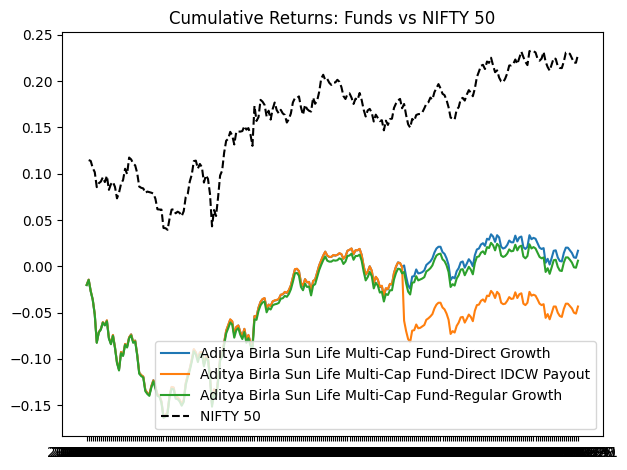

In [25]:
import matplotlib.pyplot as plt

for name, g in df.groupby("scheme_name"):
    plt.plot(g["date"], g["fund_cum_return"], label=name)

plt.plot(
    df.groupby("date")["benchmark_cum_return"].mean().index,
    df.groupby("date")["benchmark_cum_return"].mean().values,
    linestyle="--",
    color="black",
    label="NIFTY 50"
)

plt.title("Cumulative Returns: Funds vs NIFTY 50")
plt.legend()
plt.tight_layout()
plt.show()
